<a href="https://colab.research.google.com/github/aulphin/GuISE-XAI/blob/main/GuISE(k_means).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#%cd /content/drive/MyDrive/Colab Notebooks/New-Project/PASCAL-DATASET/JPEGImages

/content/drive/MyDrive/Colab Notebooks/New-Project/PASCAL-DATASET/JPEGImages


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/New-Project

/content/drive/MyDrive/Colab Notebooks/New-Project


############Guided Mask Generation#############

In [ ]:
############libraries #############
from skimage import io
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, segmentation
from sklearn.cluster import KMeans
from scipy.stats import mode

In [ ]:
import numpy as np
from PIL import Image

original_image = Image.open('bit.jpg')

original_array = np.array(original_image)


reshaped_array = np.array(Image.fromarray(original_array).resize((224, 224)))

# # Check the new shape
print("Original shape:", original_array.shape)
print("Reshaped shape:", reshaped_array.shape)


reshaped_image = Image.fromarray(reshaped_array)
reshaped_image.save("fixed_img.jpg")


Original shape: (361, 500, 3)
Reshaped shape: (224, 224, 3)


In [ ]:
# Load the original image
original_img = io.imread('fixed_img.jpg')

# Apply SLIC with an appropriate number of segments
#n_segments = original_img.shape[0] // 1024
n_segments = original_img.shape[0] * original_img.shape[1] // 256


segments_slice = slic(original_img, n_segments=n_segments, compactness=10, sigma=1, multichannel=True)

# Visualize the segmented image with color boundaries
segmented_img = mark_boundaries(original_img, segments_slice)

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:338: FutureWarning: `multichannel` is a deprecated argument name for `slic`. It will be removed in version 1.0. Please use `channel_axis` instead.
  warnings.warn(self.warning_msg.format(


In [ ]:
#Count the number of pixels in the original image
total_pixels_original = original_img.size

# Count the number of pixels in the segmented image after slicing
total_pixels_sliced = segments_slice.size

print(f"Number of pixels in the original image: {total_pixels_original}")
print(f"Number of pixels in the segmented image after slicing: {total_pixels_sliced}")

Number of pixels in the original image: 150528
Number of pixels in the segmented image after slicing: 50176


In [ ]:
 ####### K-means Clustering #########
 #Flatten the image array
flattened_img = original_img.reshape(-1, 3)

In [ ]:
# Specify the number of clusters for KMeans
num_clusters = 5

# Apply KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(flattened_img)

# Get clustered labels
clustered_labels = kmeans.labels_

# Map back to the original image shape
clustered_image = clustered_labels.reshape(original_img.shape[0], original_img.shape[1])


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
####### Assigning clusters to each segment #########
import numpy as np
from scipy.stats import mode

# Get the unique segments
unique_segments = np.unique(segments_slice)
print(len(unique_segments))
segment_clusters = {}

# Iterate through each unique segment
for segment in unique_segments:
    # Find the coordinates of pixels belonging to this segment
    coords = np.argwhere(segments_slice == segment)

    # Get the cluster IDs for these pixels
    cluster_ids = [clustered_image[x[0], x[1]] for x in coords]

    mode_result = mode(cluster_ids)
    mode_clusters = mode_result.mode

    # Assign the mode cluster ID to the segment
    segment_clusters[segment] = mode_clusters

178


In [ ]:
# color each cluster to visualize it better
unique_labels = np.unique(clustered_labels)
#print(unique_labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
#print(colors)
clustered_image_colored = np.zeros((original_img.shape[0], original_img.shape[1], 3), dtype=np.float32)
for label, color in zip(unique_labels, colors):
    clustered_image_colored[clustered_image == label] = color[:3]
#clustered_image_colored

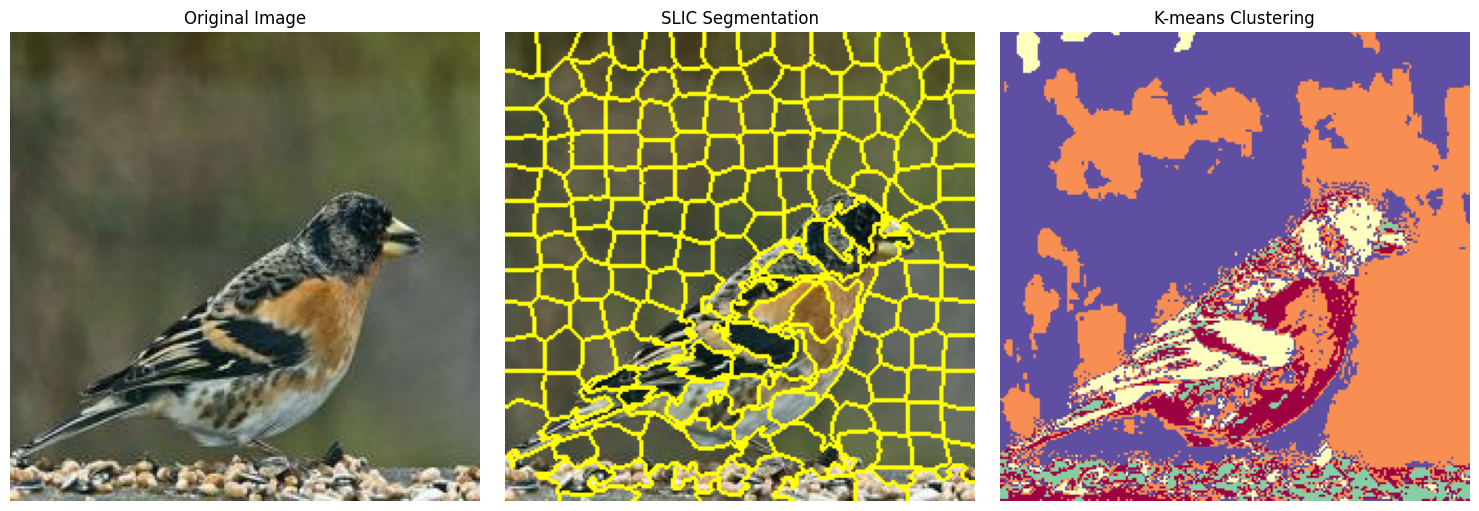

In [ ]:
# Let's plot the original image, the SLIC segmented image, and the K-means clustered image
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(original_img)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Show SLIC segmented boundaries on the original image
axes[1].imshow(segmented_img)
axes[1].set_title('SLIC Segmentation')
axes[1].axis('off')

axes[2].imshow(clustered_image_colored, extent=(0, original_img.shape[1], original_img.shape[0], 0))
#axes[2].imshow(clustered_image_colored)
axes[2].set_title('K-means Clustering')
axes[2].axis('off')

plt.tight_layout()
plt.show()

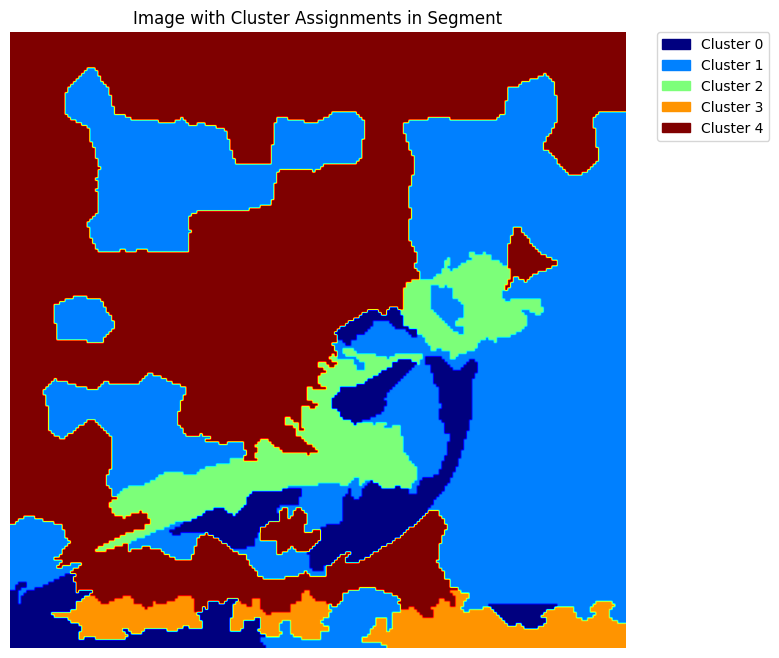

In [ ]:
# Create a color map
cmap = plt.cm.jet
norm = plt.Normalize(vmin=clustered_image.min(), vmax=clustered_image.max())

# Initialize a new image array
clustered_segments_img = np.zeros_like(segments_slice)

# Assign cluster colors to each segment
for segment, cluster in segment_clusters.items():
    clustered_segments_img[segments_slice == segment] = cluster

# Plotting the image
plt.figure(figsize=(8, 8))
plt.imshow(clustered_segments_img, cmap=cmap)
plt.title("Image with Cluster Assignments in Segment")
plt.axis('off')  # Hide the axis

# Creating the legend
# Get unique clusters and their colors
unique_clusters = np.unique(clustered_segments_img)
colors = [cmap(norm(c)) for c in unique_clusters]

# Create a patch for each color
import matplotlib.patches as mpatches
patches = [mpatches.Patch(color=colors[i], label=f'Cluster {int(unique_clusters[i])}') for i in range(len(unique_clusters))]

# Add the legend to the plot
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()


########### Histogram Implementation#################

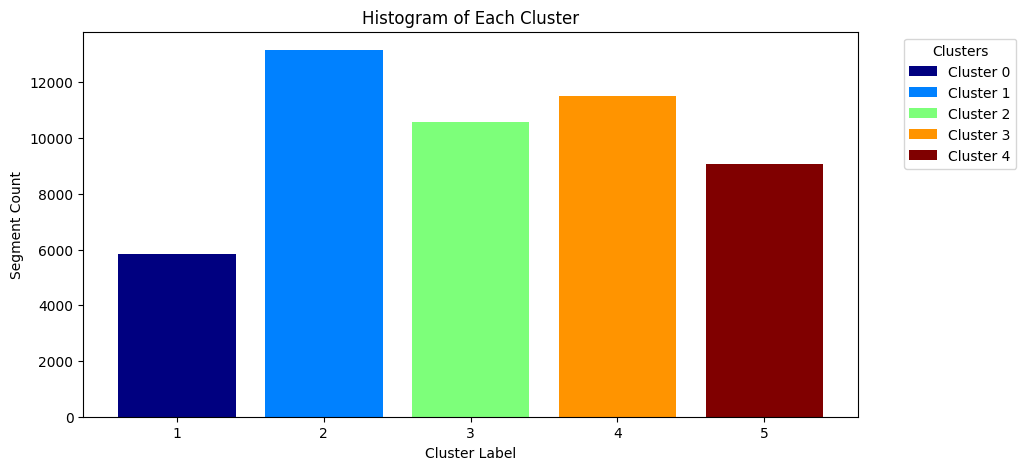

In [ ]:
k=5
# Count the pixels in each cluster
#cluster_pixel_counts = np.bincount(clustered_segments_img, minlength=k)

cluster_segment_counts = np.bincount(clustered_segments_img.flatten(), minlength=k)


# Create the histogram with colored bars
fig, ax = plt.subplots(figsize=(10, 5))

bars = ax.bar(range(k), cluster_segment_counts, color=colors)

# Labeling the axes
ax.set_xlabel('Cluster Label')
ax.set_ylabel('Segment Count')
ax.set_title('Histogram of Each Cluster')
ax.set_xticks(range(k))
ax.set_xticklabels(range(1, k + 1))

# Adding a legend to relate colors to clusters
plt.legend(bars, [f'Cluster {i}' for i in range(k)], title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the histogram
plt.show()


In [ ]:
# Total number of pixels in the image
total_pixels = original_img.shape[0] * original_img.shape[1]

# Calculate the percentage of each cluster
cluster_percentages = (cluster_segment_counts/ total_pixels) * 100

# Normalize the values to sum up to 100 and round to 2 decimal places
normalized_percentages = np.round((cluster_percentages / np.sum(cluster_percentages)) * 100, 2)
#print(normalized_percentages)
# Check if the sum is 100 after rounding, if not, adjust the last element to make the sum 100
if np.sum(normalized_percentages) != 100:
    difference = 100 - np.sum(normalized_percentages)
    normalized_percentages[-1] += difference

print(normalized_percentages)

[11.67 26.23 21.1  22.93 18.07]


In [ ]:
# #### New Computation ############3
# # normalized_percentages = np.array([26.32, 65.4, 34.99, 5.61, 11.61])
out =(normalized_percentages / 100)
#print(out)
prob = (1-out)
probabilities = np.where(out > 0.2, 0.5, np.round(prob, 2))
print(probabilities)


[0.88 0.5  0.5  0.5  0.82]


In [ ]:
# cluster labels as keys and probabilities as values
cluster_probability_dict = {cluster_label: probability for cluster_label, probability in zip(range(0, k+1 ), probabilities)}

#Create the  formatted
cluster_probability = {"cluster " + str(cluster_label): probability for cluster_label, probability in cluster_probability_dict.items()}

# Print the result
print(cluster_probability)


{'cluster 0': 0.88, 'cluster 1': 0.5, 'cluster 2': 0.5, 'cluster 3': 0.5, 'cluster 4': 0.82}


############################Guise Method ##############

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize
from tqdm import tqdm
from keras.preprocessing import image
import random

In [ ]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras import backend as K

In [ ]:
class Model():
    def __init__(self):
        K.set_learning_phase(0)
        self.model = ResNet50()
        self.input_size = (224, 224)

    def run_on_batch(self, x):
        return self.model.predict(x)

In [ ]:
model = Model()

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


102967424/102967424 [==============================] - 0s 0us/step


In [ ]:
def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

In [ ]:
def load_img(path):
    img = image.load_img(path, target_size=model.input_size)
    x = image.img_to_array(img)
    #x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [ ]:
# Value Assigning
k=5
clusters = clustered_segments_img
# Define probabilities for each cluster
probabilities = cluster_probability

In [ ]:
########## Superpixel Experimenting ################
import numpy as np
from scipy.stats import mode

def generate_segment_masks(clusters, segments, probabilities):
    unique_segments = np.unique(segments)

    segment_clusters = {}

    # Assign clusters to each segment
    for segment in unique_segments:
        coords = np.argwhere(segments == segment)
        cluster_ids = [clusters[x[0], x[1]] for x in coords]

        mode_result = mode(cluster_ids)
        mode_clusters = mode_result.mode

        segment_clusters[segment] = mode_clusters

    # Initialize an empty mask
    mask = np.zeros_like(segments, dtype=float)
    #print(mask)
     # Count the number of segments for each cluster
    cluster_segment_counts = {}
    for segment, clusters in segment_clusters.items():
        if clusters.size > 0:
            cluster_id = int(clusters)
            if cluster_id in cluster_segment_counts:
                cluster_segment_counts[cluster_id] += 1
            else:
                cluster_segment_counts[cluster_id] = 1

    #print(cluster_segment_counts)
    for cluster_id, segment_count in cluster_segment_counts.items():
    # Get the probability for the current cluster
         cluster_key = f'cluster {cluster_id}'

         if cluster_key in probabilities:
                num_ones = int(probabilities[cluster_key] * segment_count)
                #print(num_ones)
                cluster_segments = [segment for segment, cluster in segment_clusters.items() if cluster == cluster_id]
                #print(cluster_segments)
                selected_segments = random.sample(cluster_segments, num_ones)
                #print(selected_segments)
                # Assign '1' to the selected segments in the mask
                for segment in selected_segments:
                     mask[segments == segment] = 1
    return mask



In [ ]:
result_masks = generate_segment_masks(clustered_image, segments_slice, probabilities)


In [ ]:
# No of mask
N= 256
masks = np.array([generate_segment_masks(clustered_image, segments_slice, probabilities) for _ in range(N)])
print(masks.shape)


(256, 224, 224)


In [ ]:
#plt.imshow(masks[3])

In [ ]:
image_path = '/content/drive/MyDrive/Colab Notebooks/New-Project/bit.jpg'
#image_path = '/content/drive/MyDrive/Colab Notebooks/New-Project/PASCAL-DATASET/JPEGImages/000236.jpg'
img, x = load_img(image_path)

In [ ]:
batch_size = 50

def explain(model, x, masks):
    preds = []

    masked = np.empty((N, *x.shape))
    #plt.imshow(masked[0])
    for i in range(N):
              masked[i] = x* masks[i, :, :, np.newaxis]
    masked

    for i in tqdm(range(0, N, batch_size), desc='Explaining'):
        preds.append(model.run_on_batch(masked[i:min(i+batch_size, N)]))

    preds = np.concatenate(preds)
    #print("Batch Predictions:", preds[0])
    sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, *model.input_size)
    sal = sal / N



    return sal

In [ ]:
explainer = explain(model,x, masks)

Explaining:   0%|          | 0/6 [00:00<?, ?it/s]

2/2 [==============================] - 6s 1s/step


Explaining:  17%|█▋        | 1/6 [00:06<00:31,  6.37s/it]

2/2 [==============================] - 0s 76ms/step


Explaining:  33%|███▎      | 2/6 [00:06<00:11,  2.78s/it]

2/2 [==============================] - 0s 76ms/step


Explaining:  50%|█████     | 3/6 [00:07<00:05,  1.71s/it]

2/2 [==============================] - 0s 75ms/step


Explaining:  67%|██████▋   | 4/6 [00:07<00:02,  1.14s/it]

2/2 [==============================] - 0s 75ms/step


Explaining:  83%|████████▎ | 5/6 [00:07<00:00,  1.22it/s]

1/1 [==============================] - 1s 898ms/step


Explaining: 100%|██████████| 6/6 [00:08<00:00,  1.42s/it]


35363/35363 [==============================] - 0s 0us/step


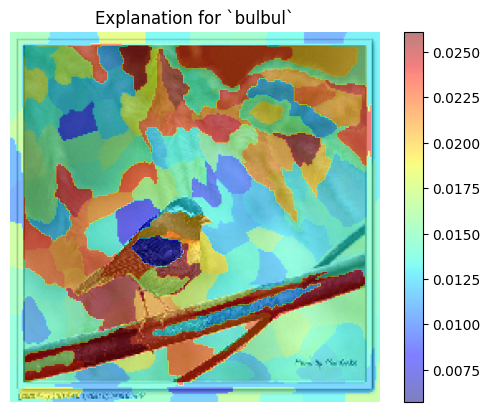

In [ ]:
class_idx = 10 #for tabby
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(img)
saliency = explainer[class_idx]
plt.imshow(saliency, cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()

Insertion and Deletion Score

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/New-Project

/content/drive/MyDrive/Colab Notebooks/New-Project


In [ ]:
# ###### Importing libraries##########
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.models as models
from torch.nn.functional import conv2d
cudnn.benchmark = True

In [ ]:
from evaluation import CausalMetric, auc, gkern
from utils import *

In [ ]:
# # Load black box model for explanations
model = models.resnet50(True)
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for p in model.parameters():
    p.requires_grad = False

# To use multiple GPUs
#model = nn.DataParallel(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 108MB/s]


Prepare Substrate FUnction

In [ ]:
klen = 11
ksig = 5
kern = gkern(klen, ksig)

# Function that blurs input image
blur = lambda x: nn.functional.conv2d(x, kern, padding=klen//2)

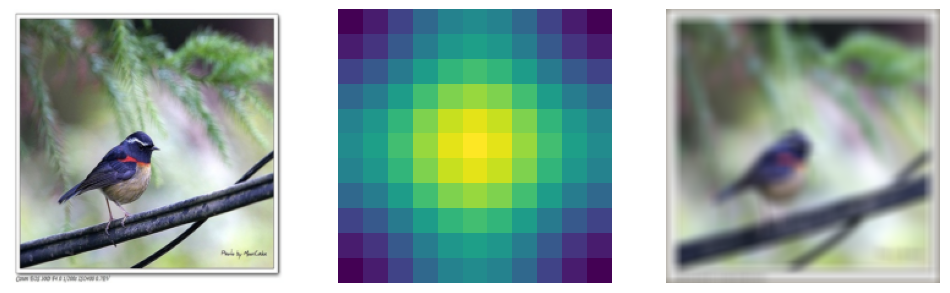

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.axis('off')
img = read_tensor('/content/drive/MyDrive/Colab Notebooks/New-Project/PASCAL-DATASET/JPEGImages/000236.jpg')
tensor_imshow(img[0])

plt.subplot(132)
plt.axis('off')
plt.imshow(kern[0, 0])

plt.subplot(133)
plt.axis('off')
tensor_imshow(blur(img)[0])
plt.show()

In [ ]:
## EXPERIMENT ON SALIENCY GENERATION

In [ ]:
######### Causal Metrics #######
insertion = CausalMetric(model, 'ins', 224, substrate_fn=blur)
deletion = CausalMetric(model, 'del', 224, substrate_fn=torch.zeros_like)

Evaluating for Single image

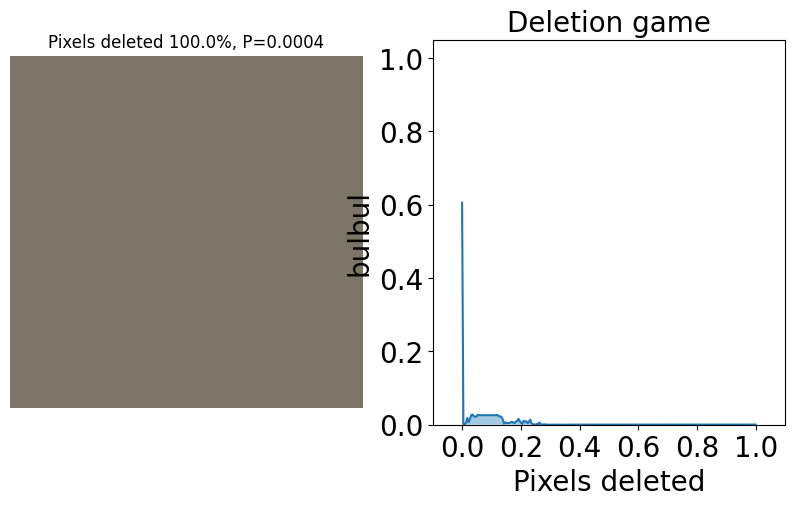

AUC: 0.005356546024919291


In [ ]:
h = deletion.single_run(img, explainer, verbose=1)

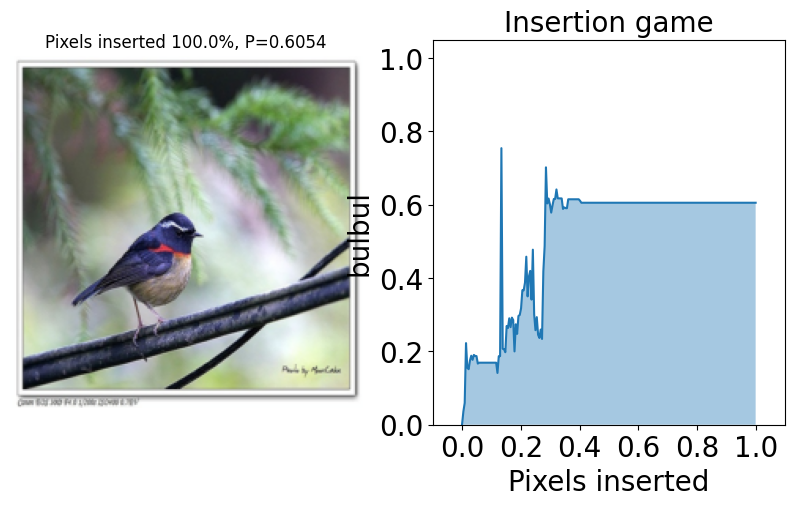

AUC: 0.5050025802351489


In [ ]:
h = insertion.single_run(img, explainer, verbose=1)